In [ ]:
!pip install --quiet torch pandas gdown nltk hf_xet gitpython datasets
!pip install -U bitsandbytes accelerate transformers peft scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 132.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

# 1.Load Dataset & Kiểm tra dữ liệu

In [ ]:
import pandas as pd
import numpy as np
import re
import os
import ast
import string
import torch
import time
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from torch.nn.utils.rnn import pad_sequence
from nltk.corpus import stopwords
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from collections import Counter
from difflib import SequenceMatcher
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from IPython.display import display, Markdown


In [ ]:
import os
import ast
import pandas as pd
import string
from difflib import SequenceMatcher


if not os.path.exists('OATS-ABSA'):
    !git clone https://github.com/RiTUAL-MBZUAI/OATS-ABSA.git

def fuzzy_match(aspect, token):
    return SequenceMatcher(None, aspect, token).ratio() > 0.7

def normalize_tokens(tokens):
    return [token.lower().strip(string.punctuation) for token in tokens]

def find_sublist_indices(tokens, aspect_term):
    aspect_tokens = normalize_tokens(aspect_term.split())
    for i in range(len(tokens) - len(aspect_tokens) + 1):
        match = all(fuzzy_match(asp_tok, tokens[i + j]) for j, asp_tok in enumerate(aspect_tokens))
        if match:
            return list(range(i, i + len(aspect_tokens)))
    return []

def convert_txt_to_csv(txt_path, csv_path):
    data = []
    with open(txt_path, 'r', encoding='utf-8') as f:
        for line in f:
            if "####" not in line:
                continue
            text, annots = line.strip().split("####")
            entries = ast.literal_eval(annots)
            if not isinstance(entries, list):
                continue
            for entry in entries:
                if len(entry) == 4:
                    aspect, category, sentiment, opinion = entry
                elif len(entry) == 3:
                    aspect, category, sentiment = entry
                    opinion = ''
                elif len(entry) == 2:
                    category, sentiment = entry
                    aspect = opinion = ''
                else:
                    continue
                data.append({
                    'sentence': text.strip(),
                    'aspect': aspect.strip(),
                    'category': category.strip(),
                    'sentiment': sentiment.strip(),
                    'opinion': opinion.strip()
                })

    os.makedirs(os.path.dirname(csv_path), exist_ok=True)
    pd.DataFrame(data).to_csv(csv_path, index=False)


base_dir = '/content/OATS-ABSA/data'
datasets = ['amazon_ff', 'coursera', 'hotels']
splits = ['train.txt', 'dev.txt', 'test.txt']

for dataset in datasets:
    for split in splits:
        txt_path = os.path.join(base_dir, dataset, 'quads', split)
        csv_path = os.path.join(base_dir, dataset, 'csv_quads', split.replace('.txt', '.csv'))
        if os.path.exists(txt_path):
            convert_txt_to_csv(txt_path, csv_path)
            print(f"Converted: {txt_path} → {csv_path}")
        else:
            print(f"File not found: {txt_path}")


Cloning into 'OATS-ABSA'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 111 (delta 5), reused 0 (delta 0), pack-reused 86 (from 1)
Receiving objects: 100% (111/111), 7.70 MiB | 10.72 MiB/s, done.
Resolving deltas: 100% (25/25), done.
Converted: /content/OATS-ABSA/data/amazon_ff/quads/train.txt → /content/OATS-ABSA/data/amazon_ff/csv_quads/train.csv
Converted: /content/OATS-ABSA/data/amazon_ff/quads/dev.txt → /content/OATS-ABSA/data/amazon_ff/csv_quads/dev.csv
Converted: /content/OATS-ABSA/data/amazon_ff/quads/test.txt → /content/OATS-ABSA/data/amazon_ff/csv_quads/test.csv
Converted: /content/OATS-ABSA/data/coursera/quads/train.txt → /content/OATS-ABSA/data/coursera/csv_quads/train.csv
Converted: /content/OATS-ABSA/data/coursera/quads/dev.txt → /content/OATS-ABSA/data/coursera/csv_quads/dev.csv
Converted: /content/OATS-ABSA/data/coursera/quads/test.txt → /content/OATS-ABSA/data/cours

In [ ]:
import os
import pandas as pd


sentiment_map = {'negative': 0, 'neutral': 1, 'positive': 2}


base_dir = '/content/OATS-ABSA/data'
datasets = ['amazon_ff', 'coursera', 'hotels']
splits = ['train', 'dev', 'test']

dataframes = {}


for dataset in datasets:
    for split in splits:
        csv_path = os.path.join(base_dir, dataset, 'csv_quads', f"{split}.csv")
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
            df['sentiment_label'] = df['sentiment'].map(sentiment_map)
            key = f"{dataset}_{split}"
            dataframes[key] = df
            print(f"Loaded & labeled: {key} → {df.shape[0]} rows")
        else:
            print(f"File not found: {csv_path}")

for name in dataframes:
    dataframes[name]['dataset'] = name


train_data = pd.concat([df for key, df in dataframes.items() if key.endswith('train')], ignore_index=True)
dev_data   = pd.concat([df for key, df in dataframes.items() if key.endswith('dev')], ignore_index=True)
test_data  = pd.concat([df for key, df in dataframes.items() if key.endswith('test')], ignore_index=True)

print(f"Train: {len(train_data)} | Dev: {len(dev_data)} | Test: {len(test_data)}")


Loaded & labeled: amazon_ff_train → 6314 rows
Loaded & labeled: amazon_ff_dev → 980 rows
Loaded & labeled: amazon_ff_test → 966 rows
Loaded & labeled: coursera_train → 6710 rows
Loaded & labeled: coursera_dev → 929 rows
Loaded & labeled: coursera_test → 236 rows
Loaded & labeled: hotels_train → 10180 rows
Loaded & labeled: hotels_dev → 1052 rows
Loaded & labeled: hotels_test → 242 rows
Train: 23204 | Dev: 2961 | Test: 1444


In [ ]:
train_data.to_csv('train_data.csv', index=False)
dev_data.to_csv('dev_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

# 2.Tiền xử lý dữ liệu (Preprocessing)


## K-Fold Cross Validation

In [ ]:
k_fold_merge_train_valid = pd.concat([train_data, dev_data], ignore_index=True)
k_fold_merge_train_valid

,sentence,aspect,category,sentiment,opinion,sentiment_label,dataset
0,The Black Bean & Lime Soup is my favorite .,Black Bean & Lime Sou,food general,positive,my favorite,2.0,amazon_ff_train
1,"It tastes fresh and homemade , has just a hint...",NaN,food quality,positive,tastes fresh and homemade,2.0,amazon_ff_train
2,"As an added bonus , it ' s good for you .",NaN,food general,positive,good for you,2.0,amazon_ff_train
3,Discovered this Hot Sauce on a recent trip to ...,Hot Sauce,food recommendation,positive,extend the experience,2.0,amazon_ff_train
4,Literally ordered it from my phone as I enjoyed .,NaN,food general,positive,enjoyed,2.0,amazon_ff_train
...,...,...,...,...,...,...,...
26160,"Spacious rooms , good bathrooms ( with towel w...",rooms,rooms design_features,positive,Spacious,2.0,hotels_dev
26161,"Spacious rooms , good bathrooms ( with towel w...",bathrooms,rooms general,positive,good,2.0,hotels_dev
26162,"Spacious rooms , good bathrooms ( with towel w...",towel warmer,room_amenities general,positive,good,2.0,hotels_dev
26163,"Spacious rooms , good bathrooms ( with towel w...",location,location general,positive,great,2.0,hotels_dev


In [ ]:
# from google.colab import files
# k_fold_merge_train_valid.to_csv('k_fold_merge_train_valid.csv', index=False)
# files.download('k_fold_merge_train_valid.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

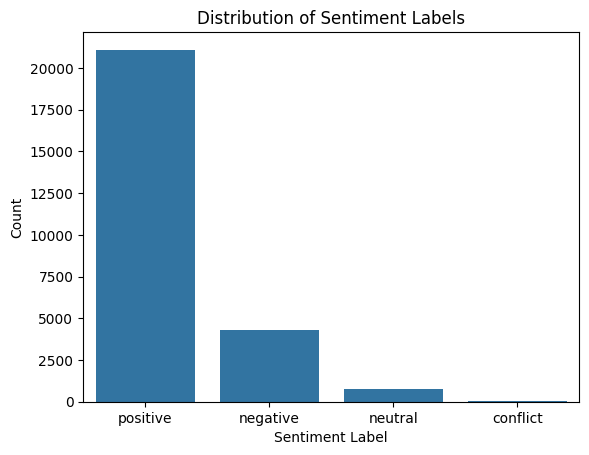

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=k_fold_merge_train_valid, x='sentiment')
plt.title("Distribution of Sentiment Labels")
plt.xlabel("Sentiment Label")
plt.ylabel("Count")
plt.show()


In [ ]:
from sklearn.model_selection import StratifiedKFold

# Bước 1: Tạo bản sao không có NaN
df_clean = k_fold_merge_train_valid.dropna(subset=['sentiment_label']).copy()
df_clean = df_clean.reset_index(drop=False)  # giữ index gốc trong cột 'index'

# Bước 2: Thêm cột fold
df_clean['fold'] = -1

# Bước 3: Stratified K-Fold
skf = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(skf.split(df_clean, df_clean['sentiment_label'])):
    df_clean.loc[val_idx, 'fold'] = fold

# Bước 4: Gán lại vào DataFrame gốc nếu muốn
k_fold_merge_train_valid['fold'] = -1  # Khởi tạo cột fold gốc
k_fold_merge_train_valid.loc[df_clean['index'], 'fold'] = df_clean['fold'].values

# Kiểm tra
print(k_fold_merge_train_valid.groupby(['fold', 'sentiment_label']).size())


fold  sentiment_label
0     0.0                 216
      1.0                  37
      2.0                1055
1     0.0                 216
      1.0                  37
      2.0                1055
2     0.0                 216
      1.0                  37
      2.0                1055
3     0.0                 216
      1.0                  37
      2.0                1055
4     0.0                 216
      1.0                  37
      2.0                1055
5     0.0                 216
      1.0                  37
      2.0                1055
6     0.0                 216
      1.0                  37
      2.0                1055
7     0.0                 216
      1.0                  37
      2.0                1055
8     0.0                 216
      1.0                  36
      2.0                1055
9     0.0                 216
      1.0                  36
      2.0                1055
10    0.0                 216
      1.0                  36
      2.0         

In [ ]:
k_fold_merge_train_valid

,sentence,aspect,category,sentiment,opinion,sentiment_label,dataset,fold
0,The Black Bean & Lime Soup is my favorite .,Black Bean & Lime Sou,food general,positive,my favorite,2.0,amazon_ff_train,4
1,"It tastes fresh and homemade , has just a hint...",NaN,food quality,positive,tastes fresh and homemade,2.0,amazon_ff_train,4
2,"As an added bonus , it ' s good for you .",NaN,food general,positive,good for you,2.0,amazon_ff_train,6
3,Discovered this Hot Sauce on a recent trip to ...,Hot Sauce,food recommendation,positive,extend the experience,2.0,amazon_ff_train,18
4,Literally ordered it from my phone as I enjoyed .,NaN,food general,positive,enjoyed,2.0,amazon_ff_train,7
...,...,...,...,...,...,...,...,...
26160,"Spacious rooms , good bathrooms ( with towel w...",rooms,rooms design_features,positive,Spacious,2.0,hotels_dev,10
26161,"Spacious rooms , good bathrooms ( with towel w...",bathrooms,rooms general,positive,good,2.0,hotels_dev,11
26162,"Spacious rooms , good bathrooms ( with towel w...",towel warmer,room_amenities general,positive,good,2.0,hotels_dev,5
26163,"Spacious rooms , good bathrooms ( with towel w...",location,location general,positive,great,2.0,hotels_dev,0


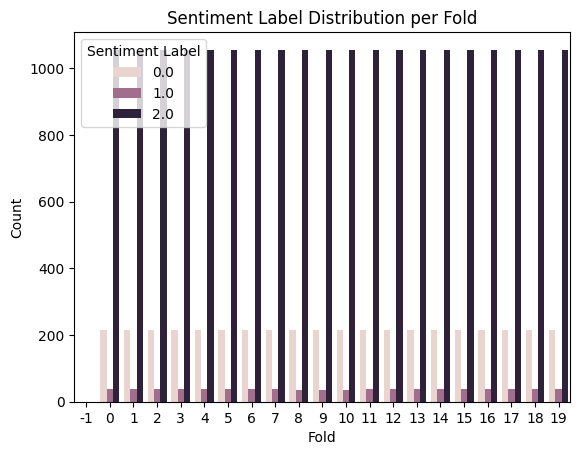

In [ ]:
sns.countplot(data=k_fold_merge_train_valid, x='fold', hue='sentiment_label')
plt.title("Sentiment Label Distribution per Fold")
plt.xlabel("Fold")
plt.ylabel("Count")
plt.legend(title="Sentiment Label")
plt.show()


In [ ]:
amazon_ff_test = test_data[test_data['dataset'] == 'amazon_ff_test']
amazon_ff_test

,sentence,aspect,category,sentiment,opinion,sentiment_label,dataset
0,"When you are low carbing , these are a good cr...",NaN,food style_options,positive,good crunchy,2,amazon_ff_test
1,"When you are low carbing , these are a good cr...",NaN,food general,positive,NaN,2,amazon_ff_test
2,I ' d also recommend Just the Cheese products ...,Cheese product,food recommendation,positive,recommend,2,amazon_ff_test
3,This is by far the best protein drink I have e...,protein drink,food quality,positive,best,2,amazon_ff_test
4,"This particular flavor is my favorite , becaus...",NaN,food general,positive,favorite,2,amazon_ff_test
...,...,...,...,...,...,...,...
961,The flavor is wonderful ; not too strong or to...,NaN,food quality,neutral,not too strong,1,amazon_ff_test
962,The flavor is wonderful ; not too strong or to...,NaN,food general,neutral,too hot,1,amazon_ff_test
963,This isn ' t a Dijon - style mustard and there...,NaN,food general,neutral,no hint,1,amazon_ff_test
964,This isn ' t a Dijon - style mustard and there...,NaN,food general,neutral,isn ' t a Dijon - style mustard,1,amazon_ff_test


## RESAMPLING

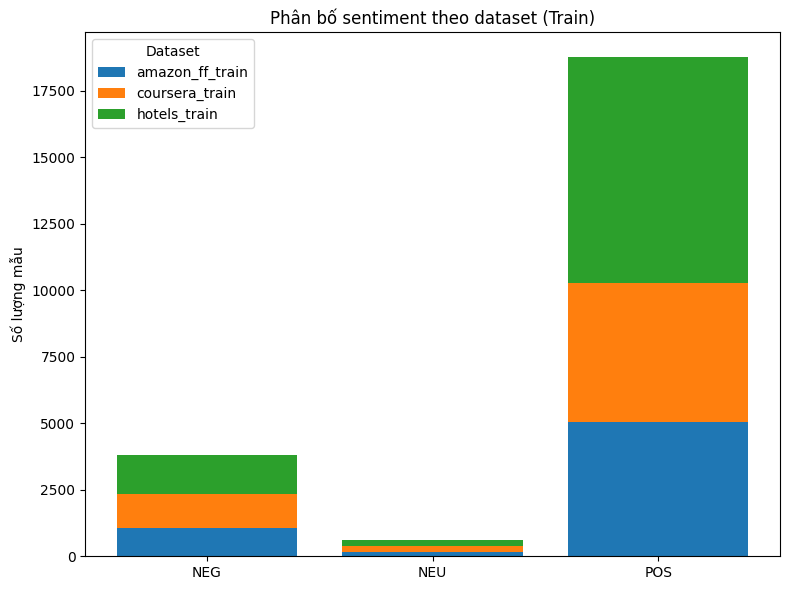

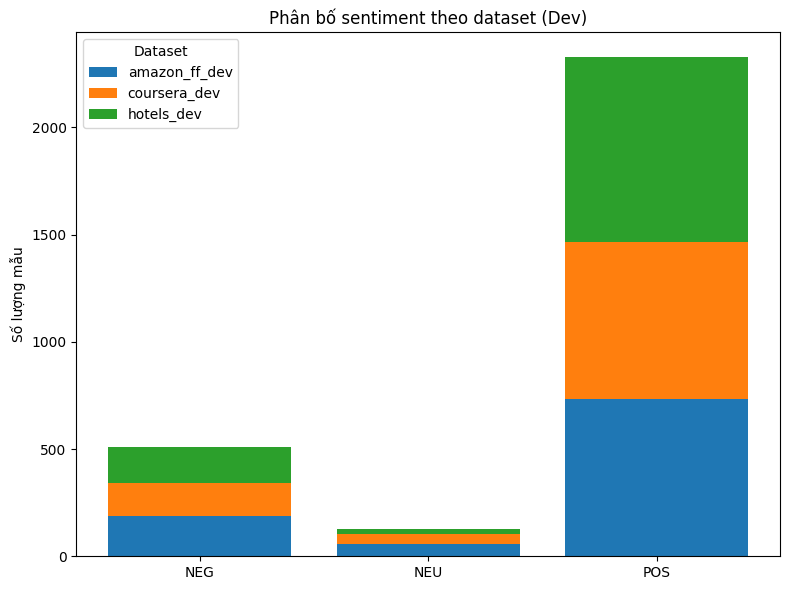

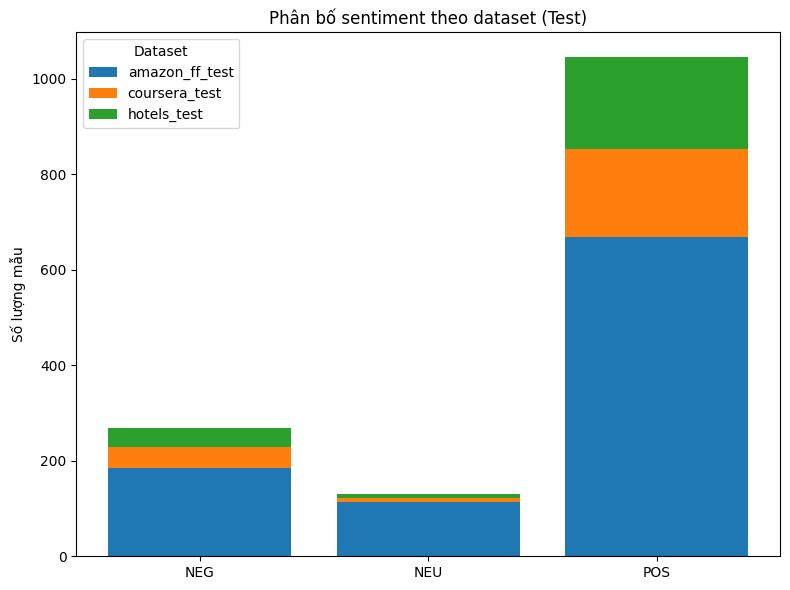

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

splits = ['train', 'dev', 'test']
labels = ['NEG', 'NEU', 'POS']
sentiment_order = [0, 1, 2]

for split in splits:
    data_split = pd.concat([df for key, df in dataframes.items() if key.endswith(split)], ignore_index=True)
    counts = data_split.groupby(['sentiment_label', 'dataset']).size().unstack(fill_value=0)
    counts = counts.reindex(sentiment_order)

    datasets = counts.columns.tolist()
    x = np.arange(len(labels))

    fig, ax = plt.subplots(figsize=(8, 6))
    bottom = np.zeros(len(labels))

    for dataset in datasets:
        ax.bar(x, counts[dataset], label=dataset, bottom=bottom)
        bottom += counts[dataset].values

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel('Số lượng mẫu')
    ax.set_title(f'Phân bố sentiment theo dataset ({split.capitalize()})')
    ax.legend(title='Dataset')

    plt.tight_layout()
    plt.show()


In [ ]:
splits = ['train', 'dev', 'test']
sentiment_order = [0, 1, 2]

for split in splits:
    data_split = pd.concat([df for key, df in dataframes.items() if key.endswith(split)], ignore_index=True)
    counts = data_split.groupby(['sentiment_label', 'dataset']).size().unstack(fill_value=0)
    counts = counts.reindex(sentiment_order)
    counts.index = ['NEG', 'NEU', 'POS']

    print("Số lượng mẫu:")
    print(counts)

Số lượng mẫu:
dataset  amazon_ff_train  coursera_train  hotels_train
NEG                 1078            1249          1481
NEU                  167             235           209
POS                 5063            5221          8484
Số lượng mẫu:
dataset  amazon_ff_dev  coursera_dev  hotels_dev
NEG                189           153         166
NEU                 56            46          24
POS                735           730         862
Số lượng mẫu:
dataset  amazon_ff_test  coursera_test  hotels_test
NEG                 185             44           39
NEU                 113              8           10
POS                 668            184          193


In [ ]:
import pandas as pd
import ast
from collections import Counter


base_path = "/content/OATS-ABSA/data"
datasets = ["hotels", "amazon_ff", "coursera"]


def load_dataset(name):
    path = f"{base_path}/{name}/csv_quads"
    train = pd.read_csv(f"{path}/train.csv")
    dev = pd.read_csv(f"{path}/dev.csv")
    test = pd.read_csv(f"{path}/test.csv")

    eval_df = pd.concat([dev, test], ignore_index=True)
    return train, eval_df


train_hotels, eval_hotels       = load_dataset("hotels")
train_amazon, eval_amazon       = load_dataset("amazon_ff")
train_coursera, eval_coursera   = load_dataset("coursera")


def count_sentiment_from_csv_quads(df, set_name):
    total = len(df)
    sentiment_counter = Counter(df['sentiment'])

    print(f"{set_name}:")
    print(f"Tổng số câu: {total}")
    print("Phân bố sentiment:")
    for label in ['negative', 'neutral', 'positive']:
        count = sentiment_counter[label]
        percent = (count / total) * 100 if total > 0 else 0
        print(f"   - {label.capitalize()}: {count} ({percent:.2f}%)")
    print("-" * 40)


count_sentiment_from_csv_quads(train_hotels, "Train_Hotels")
count_sentiment_from_csv_quads(eval_hotels, "Eval_Hotels")

count_sentiment_from_csv_quads(train_amazon, "Train_Amazon_ff")
count_sentiment_from_csv_quads(eval_amazon, "Eval_Amazon_ff")

count_sentiment_from_csv_quads(train_coursera, "Train_Coursera")
count_sentiment_from_csv_quads(eval_coursera, "Eval_Coursera")


Train_Hotels:
Tổng số câu: 10180
Phân bố sentiment:
   - Negative: 1481 (14.55%)
   - Neutral: 209 (2.05%)
   - Positive: 8484 (83.34%)
----------------------------------------
Eval_Hotels:
Tổng số câu: 1294
Phân bố sentiment:
   - Negative: 205 (15.84%)
   - Neutral: 34 (2.63%)
   - Positive: 1055 (81.53%)
----------------------------------------
Train_Amazon_ff:
Tổng số câu: 6314
Phân bố sentiment:
   - Negative: 1078 (17.07%)
   - Neutral: 167 (2.64%)
   - Positive: 5063 (80.19%)
----------------------------------------
Eval_Amazon_ff:
Tổng số câu: 1946
Phân bố sentiment:
   - Negative: 374 (19.22%)
   - Neutral: 169 (8.68%)
   - Positive: 1403 (72.10%)
----------------------------------------
Train_Coursera:
Tổng số câu: 6710
Phân bố sentiment:
   - Negative: 1249 (18.61%)
   - Neutral: 235 (3.50%)
   - Positive: 5221 (77.81%)
----------------------------------------
Eval_Coursera:
Tổng số câu: 1165
Phân bố sentiment:
   - Negative: 197 (16.91%)
   - Neutral: 54 (4.64%)
   - Positi

In [ ]:
print(train_data['sentiment_label'].value_counts(normalize=True))

sentiment_label
2.0    0.809419
0.0    0.164230
1.0    0.026351
Name: proportion, dtype: float64


In [ ]:
from sklearn.utils import resample


df_pos = train_data[train_data['sentiment_label'] == 2]
df_neu = train_data[train_data['sentiment_label'] == 1]
df_neg = train_data[train_data['sentiment_label'] == 0]

max_size = max(len(df_pos), len(df_neu), len(df_neg))


df_pos_upsampled = resample(df_pos, replace=True, n_samples=max_size, random_state=42)
df_neu_upsampled = resample(df_neu, replace=True, n_samples=max_size, random_state=42)
df_neg_upsampled = resample(df_neg, replace=True, n_samples=max_size, random_state=42)


train_data_balanced = pd.concat([df_pos_upsampled, df_neu_upsampled, df_neg_upsampled])


train_data_balanced = train_data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(train_data_balanced['sentiment_label'].value_counts())


sentiment_label
1.0    18768
2.0    18768
0.0    18768
Name: count, dtype: int64


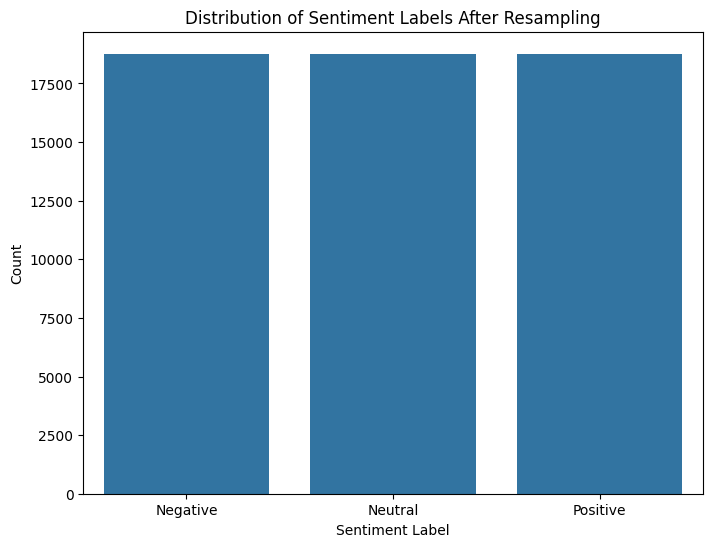

In [ ]:
sentiment_counts_balanced = train_data_balanced['sentiment_label'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts_balanced.index, y=sentiment_counts_balanced.values)
plt.title("Distribution of Sentiment Labels After Resampling")
plt.xlabel("Sentiment Label")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'])
plt.show()

In [ ]:
train_data_balanced

,sentence,aspect,category,sentiment,opinion,sentiment_label,dataset
0,BUT . . . . . . at the current ( 9 April 2010 ...,NaN,food prices,neutral,current,1.0,amazon_ff_train
1,Pros : - great location - convenient for walk...,NaN,hotel design_features,positive,nice,2.0,hotels_train
2,I ' d give it 4 / 5 once it ' s all sorted .,NaN,course general,neutral,d give it 4 / 5 once it ' s all sorted,1.0,coursera_train
3,More numbers theory and algorithms reading cou...,NaN,material quantity,neutral,NaN,1.0,coursera_train
4,"The furniture was very scuffed , and the walls...",furniture,rooms quality,negative,very scuffed,0.0,hotels_train
...,...,...,...,...,...,...,...
56299,The hotel lobby was in a chaotic state and the...,lobby,hotel general,negative,chaotic state,0.0,hotels_train
56300,The presenter emphasizes every other word and ...,presenter,faculty general,negative,talks in a very unnatural manner,0.0,coursera_train
56301,Our problem has been determmining where we can...,product,amazon availability,negative,NaN,0.0,amazon_ff_train
56302,Fine but pricey stayed here for a long weekend...,hotel,location general,positive,can't beat the location,2.0,hotels_train


In [ ]:
print(train_data_balanced.groupby('dataset')['sentiment_label'].value_counts().unstack(fill_value=0))
print(dev_data.groupby('dataset')['sentiment_label'].value_counts().unstack(fill_value=0))

sentiment_label   0.0   1.0   2.0
dataset                          
amazon_ff_train  5341  5148  5065
coursera_train   6137  7173  5155
hotels_train     7290  6447  8548
sentiment_label    0   1    2
dataset                      
amazon_ff_dev    189  56  735
coursera_dev     153  46  730
hotels_dev       166  24  862


# 3.Xây dựng và Huấn luyện mô hình

In [ ]:
# import os
# import random
# import numpy as np
# import pandas as pd
# import torch
# from torch.utils.data import Dataset, DataLoader
# from torch.nn.utils.rnn import pad_sequence
# from transformers import BertTokenizer, BertModel
# from sklearn.utils.class_weight import compute_class_weight
# from sklearn.model_selection import StratifiedKFold

# # ---------------------- Set Seed ----------------------
# def set_seed(seed=42):
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

# set_seed(42)

# # ---------------------- Parameters ----------------------
# batch_size = 520
# learning_rate = 1e-5
# num_epochs = 30
# patience = 2
# model_name = "prajjwal1/bert-mini"
# save_model_dir = "./working"
# os.makedirs(save_model_dir, exist_ok=True)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# tokenizer = BertTokenizer.from_pretrained(model_name)

# # ---------------------- Load Your DataFrame ----------------------
# # Replace with your actual dataframe
# # Example: k_fold_merge_train_valid = pd.read_csv("your_data.csv")
# k_fold_merge_train_valid = k_fold_merge_train_valid.dropna(subset=['sentence', 'sentiment_label'])
# k_fold_merge_train_valid = k_fold_merge_train_valid.reset_index(drop=True)

# # ---------------------- Stratified K-Fold ----------------------
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# k_fold_merge_train_valid['fold'] = -1
# for fold, (_, val_idx) in enumerate(skf.split(k_fold_merge_train_valid, k_fold_merge_train_valid['sentiment_label'])):
#     k_fold_merge_train_valid.loc[val_idx, 'fold'] = fold

# # ---------------------- Tokenization Function ----------------------
# def tokenize_data(df, tokenizer, max_length=128):
#     encodings = tokenizer(
#         df['sentence'].tolist(),
#         truncation=True,
#         padding='max_length',
#         max_length=max_length
#     )
#     df = df.copy()
#     df['input_ids'] = encodings['input_ids']
#     df['attention_mask'] = encodings['attention_mask']
#     df['sentiment_labels'] = df['sentiment_label'].astype(int)
#     return df

# # ---------------------- Dataset ----------------------
# class AmazonSentimentDataset(Dataset):
#     def __init__(self, df):
#         self.input_ids = df['input_ids'].tolist()
#         self.attention_masks = df['attention_mask'].tolist()
#         self.labels = df['sentiment_labels'].tolist()

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, idx):
#         return (torch.tensor(self.input_ids[idx], dtype=torch.long),
#                 torch.tensor(self.attention_masks[idx], dtype=torch.long),
#                 torch.tensor(self.labels[idx], dtype=torch.long))

# def collate_fn(batch):
#     input_ids, attention_masks, labels = zip(*batch)
#     input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
#     attention_masks = pad_sequence(attention_masks, batch_first=True, padding_value=0)
#     labels = torch.stack(labels)
#     token_type_ids = torch.zeros_like(input_ids)
#     return input_ids, token_type_ids, attention_masks, labels

# # ---------------------- Model ----------------------
# class ABSABert(torch.nn.Module):
#     def __init__(self, model_name, class_weights_tensor):
#         super(ABSABert, self).__init__()
#         self.bert = BertModel.from_pretrained(model_name)
#         self.dropout = torch.nn.Dropout(0.3)
#         self.linear = torch.nn.Linear(self.bert.config.hidden_size, 3)
#         self.loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

#     def forward(self, input_ids, token_type_ids, attention_mask, labels=None):
#         out = self.bert(input_ids=input_ids, attention_mask=attention_mask,
#                         token_type_ids=token_type_ids, return_dict=True)
#         pooled_output = self.dropout(out.pooler_output)
#         logits = self.linear(pooled_output)

#         if labels is not None:
#             loss = self.loss_fn(logits, labels)
#             return loss, logits
#         return logits

# # ---------------------- Train/Evaluate ----------------------
# def train_epoch(model, optimizer, dataloader, device, clip_value=1.0):
#     model.train()
#     total_loss, correct, total = 0, 0, 0
#     for batch in dataloader:
#         input_ids, token_type_ids, attention_mask, labels = [b.to(device) for b in batch]
#         optimizer.zero_grad()
#         loss, outputs = model(input_ids, token_type_ids, attention_mask, labels)
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
#         optimizer.step()
#         total_loss += loss.item()
#         _, preds = torch.max(outputs, dim=1)
#         correct += torch.sum(preds == labels).item()
#         total += len(labels)
#     return total_loss / len(dataloader), correct / total

# def evaluate_epoch(model, dataloader, device):
#     model.eval()
#     total_loss, correct, total = 0, 0, 0
#     with torch.no_grad():
#         for batch in dataloader:
#             input_ids, token_type_ids, attention_mask, labels = [b.to(device) for b in batch]
#             loss, outputs = model(input_ids, token_type_ids, attention_mask, labels)
#             total_loss += loss.item()
#             _, preds = torch.max(outputs, dim=1)
#             correct += torch.sum(preds == labels).item()
#             total += len(labels)
#     return total_loss / len(dataloader), correct / total

# def train_model(model, optimizer, train_loader, val_loader, num_epochs, device, patience=2):
#     best_val_loss = float('inf')
#     patience_counter = 0
#     for epoch in range(1, num_epochs + 1):
#         train_loss, train_acc = train_epoch(model, optimizer, train_loader, device)
#         val_loss, val_acc = evaluate_epoch(model, val_loader, device)

#         print(f"Epoch {epoch}:")
#         print(f"  Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}")
#         print(f"  Val   Loss = {val_loss:.4f}, Val   Acc = {val_acc:.4f}")

#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             best_model_state = model.state_dict()
#             patience_counter = 0
#         else:
#             patience_counter += 1
#             if patience_counter >= patience:
#                 print("Early stopping triggered.")
#                 break
#     return best_model_state, best_val_loss, val_acc

# # ---------------------- Run All Folds & Save Best ----------------------
# best_val_acc = 0.0
# best_model_state = None

# for fold in range(5):
#     print(f"\nFold {fold}")
#     train_df = k_fold_merge_train_valid[k_fold_merge_train_valid['fold'] != fold]
#     val_df = k_fold_merge_train_valid[k_fold_merge_train_valid['fold'] == fold]

#     train_df = tokenize_data(train_df, tokenizer)
#     val_df = tokenize_data(val_df, tokenizer)

#     y_train = train_df['sentiment_labels'].tolist()
#     class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
#     class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

#     train_ds = AmazonSentimentDataset(train_df)
#     val_ds = AmazonSentimentDataset(val_df)
#     train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
#     val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

#     model = ABSABert(model_name, class_weights_tensor).to(device)
#     optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

#     model_state, val_loss, val_acc = train_model(
#         model, optimizer, train_loader, val_loader, num_epochs, device, patience
#     )

#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         best_model_state = model_state
#         print(f"New best model at Fold {fold} with Acc = {val_acc:.4f}")

# # ---------------------- Save Final Best Model ----------------------
# final_model_path = os.path.join(save_model_dir, f"{model_name.replace('/', '_')}_BEST_10.pt")
# torch.save(best_model_state, final_model_path)
# print(f"Best model saved to: {final_model_path} (Val Acc = {best_val_acc:.4f})")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/286 [00:00<?, ?B/s]


Fold 0


pytorch_model.bin:   0%|          | 0.00/45.1M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/45.1M [00:00<?, ?B/s]

Epoch 1:
  Train Loss = 1.1078, Train Acc = 0.3772
  Val   Loss = 1.0419, Val   Acc = 0.4792
Epoch 2:
  Train Loss = 1.0635, Train Acc = 0.4850
  Val   Loss = 0.9943, Val   Acc = 0.5931
Epoch 3:
  Train Loss = 1.0312, Train Acc = 0.5584
  Val   Loss = 0.9484, Val   Acc = 0.6811


In [ ]:
# import os
# import random
# import numpy as np
# import torch
# import pandas as pd
# from torch.utils.data import Dataset, DataLoader
# from transformers import BertTokenizer, BertModel
# from torch.nn.utils.rnn import pad_sequence
# from sklearn.utils.class_weight import compute_class_weight
# from sklearn.model_selection import train_test_split


# def set_seed(seed=42):
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

# set_seed(42)
# batch_size = 520
# learning_rate = 1e-5
# num_epochs = 30
# patience = 2
# # model_name = 'bert-base-uncased'
# model_name = "prajjwal1/bert-mini"
# save_model_dir = "./working"
# os.makedirs(save_model_dir, exist_ok=True)

# tokenizer = BertTokenizer.from_pretrained(model_name)

# df = train_data_balanced
# df = df.dropna(subset=['sentence', 'sentiment_label'])


# def tokenize_data(df, tokenizer, max_length=128):
#     encodings = tokenizer(
#         df['sentence'].tolist(),
#         truncation=True,
#         padding='max_length',
#         max_length=max_length
#     )
#     df = df.copy()
#     df['input_ids'] = pd.Series(encodings['input_ids'])
#     df['attention_mask'] = pd.Series(encodings['attention_mask'])
#     df['sentiment_labels'] = df['sentiment_label'].astype(int)
#     return df

# train_data_balanced = tokenize_data(df, tokenizer)

# class AmazonSentimentDataset(Dataset):
#     def __init__(self, df):
#         self.input_ids = df['input_ids'].tolist()
#         self.attention_masks = df['attention_mask'].tolist()
#         self.labels = df['sentiment_labels'].tolist()

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, idx):
#         return (torch.tensor(self.input_ids[idx], dtype=torch.long),
#                 torch.tensor(self.attention_masks[idx], dtype=torch.long),
#                 torch.tensor(self.labels[idx], dtype=torch.long))


# def collate_fn(batch):
#     input_ids, attention_masks, labels = zip(*batch)
#     input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
#     attention_masks = pad_sequence(attention_masks, batch_first=True, padding_value=0)
#     labels = torch.stack(labels)
#     token_type_ids = torch.zeros_like(input_ids)
#     return input_ids, token_type_ids, attention_masks, labels

# train_df = train_data_balanced
# val_df = tokenize_data(dev_data, tokenizer)

# train_ds = AmazonSentimentDataset(train_df)
# val_ds = AmazonSentimentDataset(val_df)

# train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
# val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# y_train = train_df['sentiment_labels'].tolist()
# class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# class ABSABert(torch.nn.Module):
#     def __init__(self, model_name, class_weights_tensor):
#         super(ABSABert, self).__init__()
#         self.bert = BertModel.from_pretrained(model_name)
#         self.dropout = torch.nn.Dropout(0.3)
#         self.linear = torch.nn.Linear(self.bert.config.hidden_size, 3)  # 3 classes
#         self.loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

#     def forward(self, input_ids, token_type_ids, attention_mask, labels=None):
#         out = self.bert(
#             input_ids=input_ids,
#             attention_mask=attention_mask,
#             token_type_ids=token_type_ids,
#             return_dict=True
#         )
#         pooled_output = self.dropout(out.pooler_output)
#         logits = self.linear(pooled_output)

#         if labels is not None:
#             loss = self.loss_fn(logits, labels)
#             return loss, logits
#         return logits

# def train_epoch(model, optimizer, dataloader, device, clip_value=1.0):
#     model.train()
#     total_loss, correct, total = 0, 0, 0
#     for batch in dataloader:
#         input_ids, token_type_ids, attention_mask, labels = [b.to(device) for b in batch]
#         optimizer.zero_grad()
#         loss, outputs = model(input_ids, token_type_ids, attention_mask, labels)
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
#         optimizer.step()
#         total_loss += loss.item()
#         _, preds = torch.max(outputs, dim=1)
#         correct += torch.sum(preds == labels).item()
#         total += len(labels)
#     return total_loss / len(dataloader), correct / total

# def evaluate_epoch(model, dataloader, device):
#     model.eval()
#     total_loss, correct, total = 0, 0, 0
#     with torch.no_grad():
#         for batch in dataloader:
#             input_ids, token_type_ids, attention_mask, labels = [b.to(device) for b in batch]
#             loss, outputs = model(input_ids, token_type_ids, attention_mask, labels)
#             total_loss += loss.item()
#             _, preds = torch.max(outputs, dim=1)
#             correct += torch.sum(preds == labels).item()
#             total += len(labels)
#     return total_loss / len(dataloader), correct / total

# def train_model(model, optimizer, train_loader, val_loader, num_epochs, device, save_path):
#     best_val_loss = float('inf')
#     patience_counter = 0

#     for epoch in range(1, num_epochs + 1):
#         train_loss, train_acc = train_epoch(model, optimizer, train_loader, device)
#         val_loss, val_acc = evaluate_epoch(model, val_loader, device)

#         print(f"Epoch {epoch}:")
#         print(f"  Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}")
#         print(f"  Val   Loss = {val_loss:.4f}, Val   Acc = {val_acc:.4f}")

#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             patience_counter = 0
#             torch.save(model.state_dict(), save_path)
#             print("Saved model.")
#         else:
#             patience_counter += 1
#             if patience_counter >= patience:
#                 print("Early stopping triggered.")
#                 break


# model = ABSABert(model_name, class_weights_tensor).to(device)
# optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# safe_model_name = model_name.replace("/", "_")
# save_path = os.path.join(save_model_dir, f"{safe_model_name}_best.pt")
# train_model(model, optimizer, train_loader, val_loader, num_epochs, device, save_path)

In [ ]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import classification_report

# 1. Load tokenizer
model_name = "prajjwal1/bert-mini"  # hoặc "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

# 2. Hàm tokenize
def tokenize_data(df, tokenizer, max_length=128):
    encodings = tokenizer(
        df['sentence'].tolist(),
        truncation=True,
        padding='max_length',
        max_length=max_length
    )
    df = df.copy()
    df['input_ids'] = pd.Series(encodings['input_ids'])
    df['attention_mask'] = pd.Series(encodings['attention_mask'])
    df['sentiment_labels'] = df['sentiment_label'].astype(int)
    return df

# 3. Dataset class
class AmazonSentimentDataset(Dataset):
    def __init__(self, df):
        self.input_ids = df['input_ids'].tolist()
        self.attention_masks = df['attention_mask'].tolist()
        self.labels = df['sentiment_labels'].tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (torch.tensor(self.input_ids[idx], dtype=torch.long),
                torch.tensor(self.attention_masks[idx], dtype=torch.long),
                torch.tensor(self.labels[idx], dtype=torch.long))

# 4. Collate
def collate_fn(batch):
    input_ids, attention_masks, labels = zip(*batch)
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
    attention_masks = pad_sequence(attention_masks, batch_first=True, padding_value=0)
    labels = torch.stack(labels)
    token_type_ids = torch.zeros_like(input_ids)
    return input_ids, token_type_ids, attention_masks, labels

# 5. Kiến trúc mô hình giống như lúc train
class ABSABert(torch.nn.Module):
    def __init__(self, model_name):
        super(ABSABert, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(self.bert.config.hidden_size, 3)
        self.loss_fn = torch.nn.CrossEntropyLoss()  # thêm dòng này để khớp


    def forward(self, input_ids, token_type_ids, attention_mask):
        out = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True
        )
        pooled_output = self.dropout(out.pooler_output)
        logits = self.linear(pooled_output)
        return logits

# 6. Load mô hình đã huấn luyện
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ABSABert(model_name).to(device)
state_dict = torch.load('/content/prajjwal1_bert-mini_BEST_10.pt', map_location=device)
# Lọc bỏ key 'loss_fn.weight'
filtered_state_dict = {k: v for k, v in state_dict.items() if not k.startswith('loss_fn')}
model.load_state_dict(filtered_state_dict, strict=False)
model.eval()

# 7. Load và chuẩn hóa test data
test_data = pd.read_csv('/content/test_data.csv')  # hoặc đường dẫn khác
test_data = test_data.dropna(subset=['sentence', 'sentiment_label'])
test_df = tokenize_data(test_data, tokenizer)
test_ds = AmazonSentimentDataset(test_df)
test_loader = DataLoader(test_ds, batch_size=512, shuffle=False, collate_fn=collate_fn)

# 8. Đánh giá mô hình
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, token_type_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, token_type_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 9. In báo cáo
print(classification_report(all_labels, all_preds, target_names=["negative", "neutral", "positive"]))


              precision    recall  f1-score   support

    negative       0.49      0.77      0.60       268
     neutral       0.19      0.20      0.19       131
    positive       0.91      0.77      0.83      1045

    accuracy                           0.72      1444
   macro avg       0.53      0.58      0.54      1444
weighted avg       0.76      0.72      0.73      1444



In [ ]:
# # Gán nhãn tương ứng với chỉ số
# label_map = {0: 'negative', 1: 'neutral', 2: 'positive'}

# # Đảm bảo mô hình đang ở chế độ eval
# model.eval()

# # Dự đoán từng câu trong test
# for i in range(10):  # Dự đoán thử 10 câu đầu tiên
#     sentence = test_df.iloc[i]['sentence']
#     input = tokenizer.encode_plus(
#         sentence,
#         truncation=True,
#         padding='max_length',
#         max_length=128,
#         return_tensors="pt"
#     )
#     input_ids = input['input_ids'].to(device)
#     attention_mask = input['attention_mask'].to(device)
#     token_type_ids = input['token_type_ids'].to(device)

#     with torch.no_grad():
#         outputs = model(input_ids, token_type_ids, attention_mask)
#         pred = torch.argmax(outputs, dim=1).item()

#     predicted_label = label_map[pred]
#     print(f"[{predicted_label.upper()}] {sentence}")


In [ ]:
# import torch
# import pandas as pd
# import numpy as np
# from torch.utils.data import Dataset, DataLoader
# from transformers import BertTokenizer, BertModel
# from torch.nn.utils.rnn import pad_sequence
# from sklearn.metrics import classification_report

# # 1. Load tokenizer
# model_name = "prajjwal1/bert-mini"  # hoặc "bert-base-uncased"
# tokenizer = BertTokenizer.from_pretrained(model_name)

# # 2. Hàm tokenize
# def tokenize_data(df, tokenizer, max_length=128):
#     encodings = tokenizer(
#         df['sentence'].tolist(),
#         truncation=True,
#         padding='max_length',
#         max_length=max_length
#     )
#     df = df.copy()
#     df['input_ids'] = pd.Series(encodings['input_ids'])
#     df['attention_mask'] = pd.Series(encodings['attention_mask'])
#     df['sentiment_labels'] = df['sentiment_label'].astype(int)
#     return df

# # 3. Dataset class
# class AmazonSentimentDataset(Dataset):
#     def __init__(self, df):
#         self.input_ids = df['input_ids'].tolist()
#         self.attention_masks = df['attention_mask'].tolist()
#         self.labels = df['sentiment_labels'].tolist()

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, idx):
#         return (torch.tensor(self.input_ids[idx], dtype=torch.long),
#                 torch.tensor(self.attention_masks[idx], dtype=torch.long),
#                 torch.tensor(self.labels[idx], dtype=torch.long))

# # 4. Collate
# def collate_fn(batch):
#     input_ids, attention_masks, labels = zip(*batch)
#     input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
#     attention_masks = pad_sequence(attention_masks, batch_first=True, padding_value=0)
#     labels = torch.stack(labels)
#     token_type_ids = torch.zeros_like(input_ids)
#     return input_ids, token_type_ids, attention_masks, labels

# # 5. Kiến trúc mô hình giống như lúc train
# class ABSABert(torch.nn.Module):
#     def __init__(self, model_name):
#         super(ABSABert, self).__init__()
#         self.bert = BertModel.from_pretrained(model_name)
#         self.dropout = torch.nn.Dropout(0.3)
#         self.linear = torch.nn.Linear(self.bert.config.hidden_size, 3)
#         self.loss_fn = torch.nn.CrossEntropyLoss()  # thêm dòng này để khớp


#     def forward(self, input_ids, token_type_ids, attention_mask):
#         out = self.bert(
#             input_ids=input_ids,
#             attention_mask=attention_mask,
#             token_type_ids=token_type_ids,
#             return_dict=True
#         )
#         pooled_output = self.dropout(out.pooler_output)
#         logits = self.linear(pooled_output)
#         return logits

# # 6. Load mô hình đã huấn luyện
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = ABSABert(model_name).to(device)
# state_dict = torch.load('/content/bert_mini_coursera_best.pt', map_location=device)
# # Lọc bỏ key 'loss_fn.weight'
# filtered_state_dict = {k: v for k, v in state_dict.items() if not k.startswith('loss_fn')}
# model.load_state_dict(filtered_state_dict, strict=False)
# model.eval()

# # 7. Load và chuẩn hóa test data
# test_data = pd.read_csv('/content/test_data.csv')  # hoặc đường dẫn khác
# test_data = test_data.dropna(subset=['sentence', 'sentiment_label'])
# test_df = tokenize_data(test_data, tokenizer)
# test_ds = AmazonSentimentDataset(test_df)
# test_loader = DataLoader(test_ds, batch_size=512, shuffle=False, collate_fn=collate_fn)

# # 8. Đánh giá mô hình
# all_preds = []
# all_labels = []

# with torch.no_grad():
#     for batch in test_loader:
#         input_ids, token_type_ids, attention_mask, labels = [b.to(device) for b in batch]
#         outputs = model(input_ids, token_type_ids, attention_mask)
#         preds = torch.argmax(outputs, dim=1)
#         all_preds.extend(preds.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())

# # 9. In báo cáo
# print(classification_report(all_labels, all_preds, target_names=["negative", "neutral", "positive"]))


In [ ]:
# import torch
# import pandas as pd
# import numpy as np
# from torch.utils.data import Dataset, DataLoader
# from transformers import BertTokenizer, BertModel
# from torch.nn.utils.rnn import pad_sequence
# from sklearn.metrics import classification_report

# # 1. Load tokenizer
# model_name = "prajjwal1/bert-mini"  # hoặc "bert-base-uncased"
# tokenizer = BertTokenizer.from_pretrained(model_name)

# # 2. Hàm tokenize
# def tokenize_data(df, tokenizer, max_length=128):
#     encodings = tokenizer(
#         df['sentence'].tolist(),
#         truncation=True,
#         padding='max_length',
#         max_length=max_length
#     )
#     df = df.copy()
#     df['input_ids'] = pd.Series(encodings['input_ids'])
#     df['attention_mask'] = pd.Series(encodings['attention_mask'])
#     df['sentiment_labels'] = df['sentiment_label'].astype(int)
#     return df

# # 3. Dataset class
# class AmazonSentimentDataset(Dataset):
#     def __init__(self, df):
#         self.input_ids = df['input_ids'].tolist()
#         self.attention_masks = df['attention_mask'].tolist()
#         self.labels = df['sentiment_labels'].tolist()

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, idx):
#         return (torch.tensor(self.input_ids[idx], dtype=torch.long),
#                 torch.tensor(self.attention_masks[idx], dtype=torch.long),
#                 torch.tensor(self.labels[idx], dtype=torch.long))

# # 4. Collate
# def collate_fn(batch):
#     input_ids, attention_masks, labels = zip(*batch)
#     input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
#     attention_masks = pad_sequence(attention_masks, batch_first=True, padding_value=0)
#     labels = torch.stack(labels)
#     token_type_ids = torch.zeros_like(input_ids)
#     return input_ids, token_type_ids, attention_masks, labels

# # 5. Kiến trúc mô hình giống như lúc train
# class ABSABert(torch.nn.Module):
#     def __init__(self, model_name):
#         super(ABSABert, self).__init__()
#         self.bert = BertModel.from_pretrained(model_name)
#         self.dropout = torch.nn.Dropout(0.3)
#         self.linear = torch.nn.Linear(self.bert.config.hidden_size, 3)
#         self.loss_fn = torch.nn.CrossEntropyLoss()  # thêm dòng này để khớp


#     def forward(self, input_ids, token_type_ids, attention_mask):
#         out = self.bert(
#             input_ids=input_ids,
#             attention_mask=attention_mask,
#             token_type_ids=token_type_ids,
#             return_dict=True
#         )
#         pooled_output = self.dropout(out.pooler_output)
#         logits = self.linear(pooled_output)
#         return logits

# # 6. Load mô hình đã huấn luyện
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = ABSABert(model_name).to(device)
# state_dict = torch.load('/content/bert_mini_coursera_best.pt', map_location=device)
# # Lọc bỏ key 'loss_fn.weight'
# filtered_state_dict = {k: v for k, v in state_dict.items() if not k.startswith('loss_fn')}
# model.load_state_dict(filtered_state_dict, strict=False)
# model.eval()

# # 7. Load và chuẩn hóa test data
# test_data = pd.read_csv('/content/test_data.csv')  # hoặc đường dẫn khác
# test_data = test_data.dropna(subset=['sentence', 'sentiment_label'])
# test_df = tokenize_data(test_data, tokenizer)
# test_ds = AmazonSentimentDataset(test_df)
# test_loader = DataLoader(test_ds, batch_size=512, shuffle=False, collate_fn=collate_fn)

# # 8. Đánh giá mô hình
# all_preds = []
# all_labels = []

# with torch.no_grad():
#     for batch in test_loader:
#         input_ids, token_type_ids, attention_mask, labels = [b.to(device) for b in batch]
#         outputs = model(input_ids, token_type_ids, attention_mask)
#         preds = torch.argmax(outputs, dim=1)
#         all_preds.extend(preds.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())

# # 9. In báo cáo
# print(classification_report(all_labels, all_preds, target_names=["negative", "neutral", "positive"]))


In [ ]:
# import torch
# import pandas as pd
# import numpy as np
# from torch.utils.data import Dataset, DataLoader
# from transformers import BertTokenizer, BertModel
# from torch.nn.utils.rnn import pad_sequence
# from sklearn.metrics import classification_report

# # 1. Load tokenizer
# model_name = "prajjwal1/bert-mini"  # hoặc "bert-base-uncased"
# tokenizer = BertTokenizer.from_pretrained(model_name)

# # 2. Hàm tokenize
# def tokenize_data(df, tokenizer, max_length=128):
#     encodings = tokenizer(
#         df['sentence'].tolist(),
#         truncation=True,
#         padding='max_length',
#         max_length=max_length
#     )
#     df = df.copy()
#     df['input_ids'] = pd.Series(encodings['input_ids'])
#     df['attention_mask'] = pd.Series(encodings['attention_mask'])
#     df['sentiment_labels'] = df['sentiment_label'].astype(int)
#     return df

# # 3. Dataset class
# class AmazonSentimentDataset(Dataset):
#     def __init__(self, df):
#         self.input_ids = df['input_ids'].tolist()
#         self.attention_masks = df['attention_mask'].tolist()
#         self.labels = df['sentiment_labels'].tolist()

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, idx):
#         return (torch.tensor(self.input_ids[idx], dtype=torch.long),
#                 torch.tensor(self.attention_masks[idx], dtype=torch.long),
#                 torch.tensor(self.labels[idx], dtype=torch.long))

# # 4. Collate
# def collate_fn(batch):
#     input_ids, attention_masks, labels = zip(*batch)
#     input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
#     attention_masks = pad_sequence(attention_masks, batch_first=True, padding_value=0)
#     labels = torch.stack(labels)
#     token_type_ids = torch.zeros_like(input_ids)
#     return input_ids, token_type_ids, attention_masks, labels

# # 5. Kiến trúc mô hình giống như lúc train
# class ABSABert(torch.nn.Module):
#     def __init__(self, model_name):
#         super(ABSABert, self).__init__()
#         self.bert = BertModel.from_pretrained(model_name)
#         self.dropout = torch.nn.Dropout(0.3)
#         self.linear = torch.nn.Linear(self.bert.config.hidden_size, 3)
#         self.loss_fn = torch.nn.CrossEntropyLoss()  # thêm dòng này để khớp


#     def forward(self, input_ids, token_type_ids, attention_mask):
#         out = self.bert(
#             input_ids=input_ids,
#             attention_mask=attention_mask,
#             token_type_ids=token_type_ids,
#             return_dict=True
#         )
#         pooled_output = self.dropout(out.pooler_output)
#         logits = self.linear(pooled_output)
#         return logits

# # 6. Load mô hình đã huấn luyện
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = ABSABert(model_name).to(device)
# state_dict = torch.load('/content/bert_mini_amazon_best.pt', map_location=device)
# # Lọc bỏ key 'loss_fn.weight'
# filtered_state_dict = {k: v for k, v in state_dict.items() if not k.startswith('loss_fn')}
# model.load_state_dict(filtered_state_dict, strict=False)
# model.eval()

# # 7. Load và chuẩn hóa test data
# test_data = pd.read_csv('/content/test_data.csv')  # hoặc đường dẫn khác
# test_data = test_data.dropna(subset=['sentence', 'sentiment_label'])
# test_df = tokenize_data(test_data, tokenizer)
# test_ds = AmazonSentimentDataset(test_df)
# test_loader = DataLoader(test_ds, batch_size=512, shuffle=False, collate_fn=collate_fn)

# # 8. Đánh giá mô hình
# all_preds = []
# all_labels = []

# with torch.no_grad():
#     for batch in test_loader:
#         input_ids, token_type_ids, attention_mask, labels = [b.to(device) for b in batch]
#         outputs = model(input_ids, token_type_ids, attention_mask)
#         preds = torch.argmax(outputs, dim=1)
#         all_preds.extend(preds.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())

# # 9. In báo cáo
# print(classification_report(all_labels, all_preds, target_names=["negative", "neutral", "positive"]))


## TEST MODELS

In [ ]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import classification_report

# 1. Load tokenizer
model_name = "prajjwal1/bert-mini"  # hoặc "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

# 2. Hàm tokenize
def tokenize_data(df, tokenizer, max_length=128):
    encodings = tokenizer(
        df['sentence'].tolist(),
        truncation=True,
        padding='max_length',
        max_length=max_length
    )
    df = df.copy()
    df['input_ids'] = pd.Series(encodings['input_ids'])
    df['attention_mask'] = pd.Series(encodings['attention_mask'])
    df['sentiment_labels'] = df['sentiment_label'].astype(int)
    return df

# 3. Dataset class
class AmazonSentimentDataset(Dataset):
    def __init__(self, df):
        self.input_ids = df['input_ids'].tolist()
        self.attention_masks = df['attention_mask'].tolist()
        self.labels = df['sentiment_labels'].tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (torch.tensor(self.input_ids[idx], dtype=torch.long),
                torch.tensor(self.attention_masks[idx], dtype=torch.long),
                torch.tensor(self.labels[idx], dtype=torch.long))

# 4. Collate
def collate_fn(batch):
    input_ids, attention_masks, labels = zip(*batch)
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
    attention_masks = pad_sequence(attention_masks, batch_first=True, padding_value=0)
    labels = torch.stack(labels)
    token_type_ids = torch.zeros_like(input_ids)
    return input_ids, token_type_ids, attention_masks, labels

# 5. Kiến trúc mô hình giống như lúc train
class ABSABert(torch.nn.Module):
    def __init__(self, model_name):
        super(ABSABert, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(self.bert.config.hidden_size, 3)
        self.loss_fn = torch.nn.CrossEntropyLoss()  # thêm dòng này để khớp


    def forward(self, input_ids, token_type_ids, attention_mask):
        out = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True
        )
        pooled_output = self.dropout(out.pooler_output)
        logits = self.linear(pooled_output)
        return logits

# 6. Load mô hình đã huấn luyện
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ABSABert(model_name).to(device)
state_dict = torch.load('/content/prajjwal1_bert-mini_BEST_15.pt', map_location=device)
# Lọc bỏ key 'loss_fn.weight'
filtered_state_dict = {k: v for k, v in state_dict.items() if not k.startswith('loss_fn')}
model.load_state_dict(filtered_state_dict, strict=False)
model.eval()

# 7. Load và chuẩn hóa test data
test_data = pd.read_csv('/content/test_data.csv')  # hoặc đường dẫn khác
test_data = test_data.dropna(subset=['sentence', 'sentiment_label'])
test_df = tokenize_data(test_data, tokenizer)
test_ds = AmazonSentimentDataset(test_df)
test_loader = DataLoader(test_ds, batch_size=512, shuffle=False, collate_fn=collate_fn)

# 8. Đánh giá mô hình
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, token_type_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, token_type_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 9. In báo cáo
print(classification_report(all_labels, all_preds, target_names=["negative", "neutral", "positive"]))


              precision    recall  f1-score   support

    negative       0.51      0.75      0.61       268
     neutral       0.21      0.17      0.19       131
    positive       0.89      0.80      0.85      1045

    accuracy                           0.74      1444
   macro avg       0.54      0.58      0.55      1444
weighted avg       0.76      0.74      0.74      1444



In [ ]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import classification_report

# 1. Load tokenizer
model_name = "prajjwal1/bert-mini"  # hoặc "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

# 2. Hàm tokenize
def tokenize_data(df, tokenizer, max_length=128):
    encodings = tokenizer(
        df['sentence'].tolist(),
        truncation=True,
        padding='max_length',
        max_length=max_length
    )
    df = df.copy()
    df['input_ids'] = pd.Series(encodings['input_ids'])
    df['attention_mask'] = pd.Series(encodings['attention_mask'])
    df['sentiment_labels'] = df['sentiment_label'].astype(int)
    return df

# 3. Dataset class
class AmazonSentimentDataset(Dataset):
    def __init__(self, df):
        self.input_ids = df['input_ids'].tolist()
        self.attention_masks = df['attention_mask'].tolist()
        self.labels = df['sentiment_labels'].tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (torch.tensor(self.input_ids[idx], dtype=torch.long),
                torch.tensor(self.attention_masks[idx], dtype=torch.long),
                torch.tensor(self.labels[idx], dtype=torch.long))

# 4. Collate
def collate_fn(batch):
    input_ids, attention_masks, labels = zip(*batch)
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
    attention_masks = pad_sequence(attention_masks, batch_first=True, padding_value=0)
    labels = torch.stack(labels)
    token_type_ids = torch.zeros_like(input_ids)
    return input_ids, token_type_ids, attention_masks, labels

# 5. Kiến trúc mô hình giống như lúc train
class ABSABert(torch.nn.Module):
    def __init__(self, model_name):
        super(ABSABert, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(self.bert.config.hidden_size, 3)
        self.loss_fn = torch.nn.CrossEntropyLoss()  # thêm dòng này để khớp


    def forward(self, input_ids, token_type_ids, attention_mask):
        out = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True
        )
        pooled_output = self.dropout(out.pooler_output)
        logits = self.linear(pooled_output)
        return logits

# 6. Load mô hình đã huấn luyện
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ABSABert(model_name).to(device)
state_dict = torch.load('/content/prajjwal1_bert-mini_BEST_20.pt', map_location=device)
# Lọc bỏ key 'loss_fn.weight'
filtered_state_dict = {k: v for k, v in state_dict.items() if not k.startswith('loss_fn')}
model.load_state_dict(filtered_state_dict, strict=False)
model.eval()

# 7. Load và chuẩn hóa test data
test_data = pd.read_csv('/content/test_data.csv')  # hoặc đường dẫn khác
test_data = test_data.dropna(subset=['sentence', 'sentiment_label'])
test_df = tokenize_data(test_data, tokenizer)
test_ds = AmazonSentimentDataset(test_df)
test_loader = DataLoader(test_ds, batch_size=512, shuffle=False, collate_fn=collate_fn)

# 8. Đánh giá mô hình
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, token_type_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, token_type_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 9. In báo cáo
print(classification_report(all_labels, all_preds, target_names=["negative", "neutral", "positive"]))


              precision    recall  f1-score   support

    negative       0.50      0.77      0.60       268
     neutral       0.25      0.19      0.21       131
    positive       0.90      0.80      0.84      1045

    accuracy                           0.74      1444
   macro avg       0.55      0.59      0.55      1444
weighted avg       0.76      0.74      0.74      1444



In [ ]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import classification_report

# 1. Load tokenizer
model_name = "prajjwal1/bert-mini"  # hoặc "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

# 2. Hàm tokenize
def tokenize_data(df, tokenizer, max_length=128):
    encodings = tokenizer(
        df['sentence'].tolist(),
        truncation=True,
        padding='max_length',
        max_length=max_length
    )
    df = df.copy()
    df['input_ids'] = pd.Series(encodings['input_ids'])
    df['attention_mask'] = pd.Series(encodings['attention_mask'])
    df['sentiment_labels'] = df['sentiment_label'].astype(int)
    return df

# 3. Dataset class
class AmazonSentimentDataset(Dataset):
    def __init__(self, df):
        self.input_ids = df['input_ids'].tolist()
        self.attention_masks = df['attention_mask'].tolist()
        self.labels = df['sentiment_labels'].tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (torch.tensor(self.input_ids[idx], dtype=torch.long),
                torch.tensor(self.attention_masks[idx], dtype=torch.long),
                torch.tensor(self.labels[idx], dtype=torch.long))

# 4. Collate
def collate_fn(batch):
    input_ids, attention_masks, labels = zip(*batch)
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
    attention_masks = pad_sequence(attention_masks, batch_first=True, padding_value=0)
    labels = torch.stack(labels)
    token_type_ids = torch.zeros_like(input_ids)
    return input_ids, token_type_ids, attention_masks, labels

# 5. Kiến trúc mô hình giống như lúc train
class ABSABert(torch.nn.Module):
    def __init__(self, model_name):
        super(ABSABert, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(self.bert.config.hidden_size, 3)
        self.loss_fn = torch.nn.CrossEntropyLoss()  # thêm dòng này để khớp


    def forward(self, input_ids, token_type_ids, attention_mask):
        out = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True
        )
        pooled_output = self.dropout(out.pooler_output)
        logits = self.linear(pooled_output)
        return logits

# 6. Load mô hình đã huấn luyện
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ABSABert(model_name).to(device)
state_dict = torch.load('/content/prajjwal1_bert-mini_BEST_20_amazon.pt', map_location=device)
# Lọc bỏ key 'loss_fn.weight'
filtered_state_dict = {k: v for k, v in state_dict.items() if not k.startswith('loss_fn')}
model.load_state_dict(filtered_state_dict, strict=False)
model.eval()

# 7. Load và chuẩn hóa test data
test_data = pd.read_csv('/content/test_data.csv')  # hoặc đường dẫn khác
test_data = test_data.dropna(subset=['sentence', 'sentiment_label'])
test_df = tokenize_data(test_data, tokenizer)
test_ds = AmazonSentimentDataset(test_df)
test_loader = DataLoader(test_ds, batch_size=512, shuffle=False, collate_fn=collate_fn)

# 8. Đánh giá mô hình
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, token_type_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, token_type_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 9. In báo cáo
print(classification_report(all_labels, all_preds, target_names=["negative", "neutral", "positive"]))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/45.1M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/45.1M [00:00<?, ?B/s]

              precision    recall  f1-score   support

    negative       0.48      0.72      0.58       268
     neutral       0.27      0.18      0.21       131
    positive       0.89      0.82      0.85      1045

    accuracy                           0.74      1444
   macro avg       0.55      0.57      0.55      1444
weighted avg       0.76      0.74      0.74      1444

